# Import Statements

In [1]:
%matplotlib inline

import collections
import csv
import fitsio as fio
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np 
import operator
import os
import pandas as pd  
import pickle
import random

from astropy.table import Table

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

from nltk.classify import PositiveNaiveBayesClassifier

from sklearn import utils, svm, metrics, preprocessing, linear_model, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from __future__ import division

# Functions + Constants

In [2]:
# Edit this to where files are stored on your computer
fits_data_loc = "/Users/mulan/desktop/fits_data/"

# Edit this to number of labelling categories
global NUM_CAT
NUM_CAT = 15

# Edit this to the labelling category names
categories = ["Narrow Diagonal Signal (1)", "Narrow Diagonal Signal (1+)", "Narrow Horizontal Signal",
      "Narrow Vertical Signal (1)", "Narrow Vertical Signal (even)", "Narrow Vertical Signal (inf)",
      "Wide Diagonal Signal (1)", "Wide Diagonal Signal (1+)", "Wide Horizontal Signal",
      "Wide Vertical Signal (1)", "Wide Vertical Signal (even)", "Wide Vertical Signal (inf)",
      "No Signal", "Combination Signal", "Signal of Interest"]

def plot_name(x):
    """ Plot ON/OFF pair by name. """
    on_plt = fio.read(fits_data_loc + x + ".fits")
    off_plt = fio.read(fits_data_loc + x + "_OFF.fits")
    vmax = max([np.max(on_plt), np.max(off_plt)])
    vmin = min([np.min(on_plt), np.min(off_plt)])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
    ax1.imshow(on_plt, aspect=15, vmax=vmax, vmin=vmin, cmap = "viridis")
    ax1.set_adjustable('box-forced')
    ax1.set_title('ON image')
    ax2.imshow(off_plt, aspect=15, vmax=vmax, vmin=vmin, cmap = "viridis")
    ax2.set_adjustable('box-forced')
    ax2.set_title('OFF image')
    f.suptitle(x) 
    
def plot_name_2(x):
    """ Plot ON by name. """
    on_plt = fio.read(fits_data_loc + x + ".fits")
    vmax = max([np.max(on_plt), np.max(off_plt)])
    vmin = min([np.min(on_plt), np.min(off_plt)])
    f, ax1 = plt.subplots(1, 2, figsize=(12,4))
    ax1.imshow(on_plt, aspect=15, vmax=vmax, vmin=vmin, cmap = "viridis")
    ax1.set_adjustable('box-forced')
    ax1.set_title('ON image')
    f.suptitle(x) 

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20)) 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize='30')
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize='25')
    plt.yticks(tick_marks, classes, fontsize='25')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize=25,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30, labelpad=20)
    plt.xlabel('Predicted label', fontsize=30,labelpad=20)

def plot_distribution(total = False):

    ind = np.arange(NUM_CAT)  # the x locations for the groups
    width = 0.25              # the width of the bars

    fig, ax = plt.subplots()
    
    if total:
        total_plot = ax.bar(ind, [ALL_files.length(x) for x in range(NUM_CAT)], width, color='r')
        on_plot = ax.bar(ind + width, [ON_files.length(x) for x in range(NUM_CAT)], width, color='y')
        off_plot = ax.bar(ind + 2 * width, [OFF_files.length(x) for x in range(NUM_CAT)], width, color='g')
        ax.legend((total_plot[0], on_plot[0], off_plot[0]), ('total', 'ON', 'OFF'), fontsize='20')
        ax.set_xticks(ind + width*1.5)
        
        for rect in total_plot:
            height = rect.get_height()
            percentage = round(int(height) / ALL_files.length(), 2) * 100
            ax.text(rect.get_x() + 1.05 * rect.get_width(), 1.05*height,
                '%d' % percentage + '%',
                ha='center', va='bottom', fontsize='20')

    else:
        on_plot = ax.bar(ind, [ON_files.length(x) for x in range(NUM_CAT)], width, color='y')
        off_plot = ax.bar(ind + width, [OFF_files.length(x) for x in range(NUM_CAT)], width, color='g')
        ax.legend((on_plot[0], off_plot[0]), ('ON', 'OFF'), fontsize='20')
        ax.set_xticks(ind + width)
    
    ax.set_ylabel('Number of files', fontsize='20')
    ax.set_xlabel('Type of Signal', fontsize='20')

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 24
    fig_size[1] = 16
    plt.rcParams["figure.figsize"] = fig_size
                  
    plt.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(categories)
    plt.xticks(rotation=90)

    ax.set_title("Distribution of Labels", fontsize=30)
    

    plt.show()


In [3]:
relevant_features_f = [
 'targ_X', 'targ_Y', 'unique', 'log_0-2.5/0', 'log_0-2.5/1', 'log_0-2.5/2',
 'log_0-2.5/3', 'log_0-2.5/4', 'log_0-2.5/5', 'log_0-2.5/6', 'log_0-2.5/7',
 'log_2.5-45', 'log_45-87.5', 'log_87.5-92.5', 'log_92.5-135', 'log_135-177.5',
 'log_177.5-180/0', 'log_177.5-180/1', 'log_177.5-180/2', 'log_177.5-180/3',
 'log_177.5-180/4', 'log_177.5-180/5', 'log_177.5-180/6', 'log_177.5-180/7',
 'binary_0', 'binary_0-2.5/1', 'binary_0_0-2.5/2', 'binary_0_0-2.5/3',
 'binary_0g_0-2.5/4', 'binary_0-2.5/5', 'binary_0-2.5/6', 'binary_0-2.5/7',
 'binary_2.5-45', 'binary_45-87.5', 'binary_87.5-92.5', 'binary_92.5-135',
 'binary_135-177.5', 'binary_177.5-180/0', 'binary_177.5-180/1',
 'binary_177.5-180/2', 'binary_177.5-180/3', 'binary_177.5-180/4',
 'binary_177.5-180/5', 'binary_177.5-180/6', 'binary_177.5-180/7',
 'hog_0', 'hog_0-2.5/1', 'hog_0_0-2.5/2', 'hog_0_0-2.5/3', 'hog_0g_0-2.5/4',
 'hog_0-2.5/5', 'hog_0-2.5/6', 'hog_0-2.5/7', 'hog_2.5-45', 'hog_45-87.5',
 'hog_87.5-92.5', 'hog_92.5-135', 'hog_135-177.5', 'hog_177.5-180/0',
 'hog_177.5-180/1', 'hog_177.5-180/2', 'hog_177.5-180/3', 'hog_177.5-180/4',
 'hog_177.5-180/5', 'hog_177.5-180/6', 'hog_177.5-180/7', 'feature'
]

relevant_features = [
 'targ_X', 'targ_Y', 'unique', 'log_0-2.5/0', 'log_0-2.5/1', 'log_0-2.5/2',
 'log_0-2.5/3', 'log_0-2.5/4', 'log_0-2.5/5', 'log_0-2.5/6', 'log_0-2.5/7',
 'log_2.5-45', 'log_45-87.5', 'log_87.5-92.5', 'log_92.5-135', 'log_135-177.5',
 'log_177.5-180/0', 'log_177.5-180/1', 'log_177.5-180/2', 'log_177.5-180/3',
 'log_177.5-180/4', 'log_177.5-180/5', 'log_177.5-180/6', 'log_177.5-180/7',
 'binary_0', 'binary_0-2.5/1', 'binary_0_0-2.5/2', 'binary_0_0-2.5/3',
 'binary_0g_0-2.5/4', 'binary_0-2.5/5', 'binary_0-2.5/6', 'binary_0-2.5/7',
 'binary_2.5-45', 'binary_45-87.5', 'binary_87.5-92.5', 'binary_92.5-135',
 'binary_135-177.5', 'binary_177.5-180/0', 'binary_177.5-180/1',
 'binary_177.5-180/2', 'binary_177.5-180/3', 'binary_177.5-180/4',
 'binary_177.5-180/5', 'binary_177.5-180/6', 'binary_177.5-180/7',
 'hog_0', 'hog_0-2.5/1', 'hog_0_0-2.5/2', 'hog_0_0-2.5/3', 'hog_0g_0-2.5/4',
 'hog_0-2.5/5', 'hog_0-2.5/6', 'hog_0-2.5/7', 'hog_2.5-45', 'hog_45-87.5',
 'hog_87.5-92.5', 'hog_92.5-135', 'hog_135-177.5', 'hog_177.5-180/0',
 'hog_177.5-180/1', 'hog_177.5-180/2', 'hog_177.5-180/3', 'hog_177.5-180/4',
 'hog_177.5-180/5', 'hog_177.5-180/6', 'hog_177.5-180/7'
]


relevant_features_ON = [
 'ON_targ_X', 'ON_targ_Y', 'ON_unique', 'log_0-2.5/0', 'log_0-2.5/1',
 'log_0-2.5/2', 'log_0-2.5/3', 'log_0-2.5/4', 'log_0-2.5/5', 'log_0-2.5/6',
 'log_0-2.5/7', 'log_2.5-45', 'log_45-87.5', 'log_87.5-92.5', 'log_92.5-135',
 'log_135-177.5', 'log_177.5-180/0', 'log_177.5-180/1', 'log_177.5-180/2',
 'log_177.5-180/3', 'log_177.5-180/4', 'log_177.5-180/5', 'log_177.5-180/6',
 'log_177.5-180/7', 'binary_0', 'binary_0-2.5/1', 'binary_0_0-2.5/2',
 'binary_0_0-2.5/3', 'binary_0g_0-2.5/4', 'binary_0-2.5/5', 'binary_0-2.5/6',
 'binary_0-2.5/7', 'binary_2.5-45', 'binary_45-87.5', 'binary_87.5-92.5',
 'binary_92.5-135', 'binary_135-177.5', 'binary_177.5-180/0', 'binary_177.5-180/1',
 'binary_177.5-180/2', 'binary_177.5-180/3', 'binary_177.5-180/4', 'binary_177.5-180/5',
 'binary_177.5-180/6', 'binary_177.5-180/7', 'hog_0', 'hog_0-2.5/1',
 'hog_0_0-2.5/2', 'hog_0_0-2.5/3', 'hog_0g_0-2.5/4', 'hog_0-2.5/5', 'hog_0-2.5/6',
 'hog_0-2.5/7', 'hog_2.5-45', 'hog_45-87.5', 'hog_87.5-92.5', 'hog_92.5-135',
 'hog_135-177.5', 'hog_177.5-180/0', 'hog_177.5-180/1', 'hog_177.5-180/2',
 'hog_177.5-180/3', 'hog_177.5-180/4', 'hog_177.5-180/5', 'hog_177.5-180/6',
 'hog_177.5-180/7', 'feature'
]

relevant_features_OFF = [
 'OFF_targ_X', 'OFF_targ_Y', 'OFF_unique', 'log_0-2.5/0_F', 'log_0-2.5/1_F',
 'log_0-2.5/2_F', 'log_0-2.5/3_F', 'log_0-2.5/4_F', 'log_0-2.5/5_F',
 'log_0-2.5/6_F', 'log_0-2.5/7_F', 'log_2.5-45_F', 'log_45-87.5_F',
 'log_87.5-92.5_F', 'log_92.5-135_F', 'log_135-177.5_F', 'log_177.5-180/0_F',
 'log_177.5-180/1_F', 'log_177.5-180/2_F', 'log_177.5-180/3_F', 'log_177.5-180/4_F',
 'log_177.5-180/5_F', 'log_177.5-180/6_F', 'log_177.5-180/7_F', 'binary_0-2.5/0_F',
 'binary_0-2.5/1_F', 'binary_0-2.5/2_F', 'binary_0-2.5/3_F', 'binary_0-2.5/4_F',
 'binary_0-2.5/5_F', 'binary_0-2.5/6_F', 'binary_0-2.5/7_F', 'binary_2.5-45_F',
 'binary_45-87.5_F', 'binary_87.5-92.5_F', 'binary_92.5-135_F', 'binary_135-177.5_F',
 'binary_177.5-180/0_F', 'binary_177.5-180/1_F', 'binary_177.5-180/2_F',
 'binary_177.5-180/3_F', 'binary_177.5-180/4_F', 'binary_177.5-180/5_F',
 'binary_177.5-180/6_F', 'binary_177.5-180/7_F', 'hog_0-2.5/0_F',
 'hog_0-2.5/1_F', 'hog_0-2.5/2_F', 'hog_0-2.5/3_F', 'hog_0-2.5/4_F',
 'hog_0-2.5/5_F', 'hog_0-2.5/6_F', 'hog_0-2.5/7_F', 'hog_2.5-45_F',
 'hog_45-87.5_F', 'hog_87.5-92.5_F', 'hog_92.5-135_F', 'hog_135-177.5_F',
 'hog_177.5-180/0_F', 'hog_177.5-180/1_F', 'hog_177.5-180/2_F',
 'hog_177.5-180/3_F', 'hog_177.5-180/4_F', 'hog_177.5-180/5_F',
 'hog_177.5-180/6_F', 'hog_177.5-180/7_F', 'feature'
]

# Defined Classes

In [4]:
class Category:
        
    def __init__(self, typ):
        self.type = typ 
        self.data = [[] for i in range(NUM_CAT)]
                
    def add(self, cat, name):
        if self.type == 'OFF':
            self.data[cat].append(name[:-9])
        else:
            self.data[cat].append(name[:-5])
    
    def delete(self, cat):
        self.data.pop(cat)
        
    def length(self, cat = 'None'):
        if cat == 'None':
            return len([x for sublist in self.data for x in sublist])
        else:
            return len(self.data[cat])
        
    def percentage(self, cat):
        return (self.length(cat) / sum([self.length(x) for x in range(NUM_CAT)])) * 100
    
    def get_data(self, ind = 'None'):
        if ind == 'None':
            return self.data
        else:
            return self.data[ind]

# Loading in Data from GUI Labelling

In [5]:
result = []
fits_data_loc = "/Users/mulan/desktop/fits_data/"
wrong_label = []
error = []

# This gets all the files which I've labelled.

path = 'c:\\'
extension = 'csv'
result = []
files = ["{0:03}".format(i) for i in range(190)]
files.remove('000')

for x in files:
    os.chdir("/Users/mulan/fits_label/" + x)
    if glob.glob('*.{}'.format(extension)):
        a = (glob.glob('*.{}'.format(extension)))[0]
        result.append(a)
    
print(result)
print("")

result_files = []
for x in result:
    a = os.listdir("/Users/mulan/fits_label/" + x[:3] + "/")
    a = [x for x in a if x[-4:] == 'fits']
    result_files.extend(a)
    
os.chdir('/Users/mulan/breakthrough/bl-interns/mulanxia')

with open('labelled_files.npy', 'wb') as outfile:
    pickle.dump(result_files, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    
result_files_ON = [x[:-5] for x in result_files if x[-9:] != "_OFF.fits"]
result_files_OFF = [x[:-9] for x in result_files if x[-9:] == "_OFF.fits"]
    
d = {}
for x in range(len(result)):
    with open("/Users/mulan/fits_label/" + result[x][:3] + "/" + result[x]) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV)
        for row in readCSV:
            file_name = (row[0][28:])
            category = row[1]
            d[file_name] = category
            
print(str(len(result)) + " folders have been labelled so far.")
print(str(len(d)) + " files have been labelled so far.")

labels = pd.read_pickle('binary_log_hog_dataframe.pkl')
labels['feature_ON'] = pd.Series(np.full((labels.shape[0],), float('nan')), index=labels.index)
labels['feature_OFF'] = pd.Series(np.full((labels.shape[0],), float('nan')), index=labels.index)

ON_dict = dict((key,value) for key, value in d.iteritems() if key[-9:] != "_OFF.fits")
OFF_dict = dict((key,value) for key, value in d.iteritems() if key[-9:] == "_OFF.fits")

for key, value in d.iteritems():
    if key[-9:] != "_OFF.fits":
        labels.loc[key[:-5], 'feature_ON'] = int(value)
    else:
        labels.loc[key[:-9], 'feature_OFF'] = int(value)

with open('labelled_binary_log_hog_dataframe.pkl', 'wb') as outfile:
    pickle.dump(labels, outfile, protocol=pickle.HIGHEST_PROTOCOL)

['001_labels.csv', '003_labels.csv', '004_labels.csv', '005_labels.csv', '006_labels.csv', '008_labels.csv', '025_labels.csv', '026_labels.csv', '043_labels.csv', '048_labels.csv', '049_labels.csv', '058_labels.csv', '090_labels.csv', '098_labels.csv', '117_labels.csv', '120_labels.csv', '121_labels.csv', '125_labels.csv', '133_labels.csv', '137_labels.csv', '138_labels.csv', '140_labels.csv', '143_labels.csv', '145_labels.csv', '156_labels.csv', '158_labels.csv', '168_labels.csv', '177_labels.csv', '180_labels.csv', '181_labels.csv', '182_labels.csv', '184_labels.csv', '185_labels.csv', '186_labels.csv']

34 folders have been labelled so far.
17000 files have been labelled so far.


In [ ]:
ON_dict = dict((key,value) for key, value in d.iteritems() if key[-9:] != "_OFF.fits")
OFF_dict = dict((key,value) for key, value in d.iteritems() if key[-9:] == "_OFF.fits")

ALL_files = Category('ALL')
ON_files = Category('ON')
OFF_files = Category('OFF')

for name, cat in d.iteritems():
    if name[-9:] == '_OFF.fits':
        OFF_files.add(int(cat), name)
    else:
        ON_files.add(int(cat), name)
    ALL_files.add(int(cat), name)

Total ON files labelled: 8018
Total OFF files labelled: 7869
Total files labelled: 15909


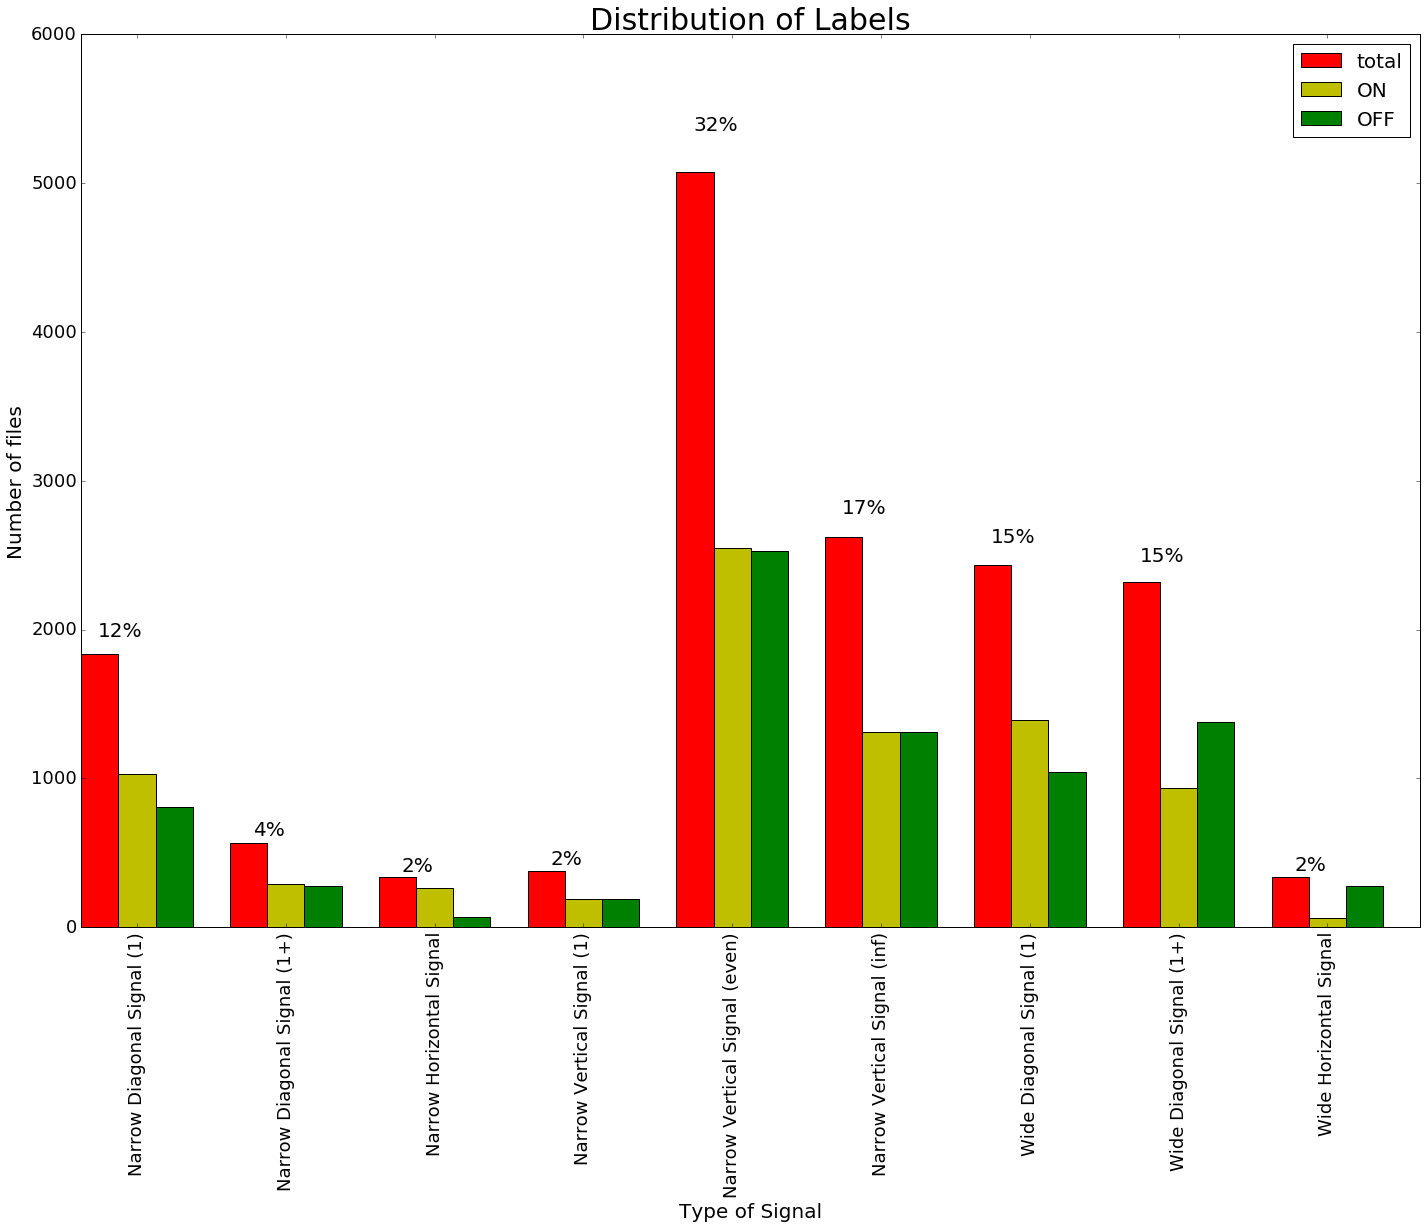

In [42]:
print("Total ON files labelled: " + str(ON_files.length()))
print("Total OFF files labelled: " + str(OFF_files.length()))
print("Total files labelled: " + str(ALL_files.length()))

plot_distribution(True)

# Removing Unneccessary Files

In [7]:
# Getting rid of combination category (dump it all as 'unknown')
removed_cat = [13]

# Remove all categories which have under 100 labelled samples
for x in range(len(categories)):
    if ALL_files.length(x) < 100:
        removed_cat.append(x)
ALL_files.data = [element for i, element in enumerate(ALL_files.data) if i not in removed_cat]
ON_files.data = [element for i, element in enumerate(ON_files.data) if i not in removed_cat]
OFF_files.data = [element for i, element in enumerate(OFF_files.data) if i not in removed_cat]

# Modified category labels based on dumped categories
categories_mod = [element for i, element in enumerate(categories) if i not in removed_cat]
categories_ind_mod = [i for i, element in enumerate(categories) if i not in removed_cat]


# Modified number of categories
NUM_CAT = len(categories_mod)

In [10]:
ALL_files_names = [x for sublist in ALL_files.get_data() for x in sublist if x[-4:] != '_OFF']

f_ON = pd.read_pickle('labelled_binary_log_hog_dataframe.pkl')
f_ON = f_ON.loc[ALL_files_names]
f_ON = f_ON[relevant_features_ON[:-1] + ['feature_ON']]
f_ON.columns = relevant_features_f

f_OFF = pd.read_pickle('labelled_binary_log_hog_dataframe.pkl')
f_OFF = f_OFF.loc[ALL_files_names]
f_OFF = f_OFF[relevant_features_OFF[:-1] + ['feature_OFF']]
f_OFF.columns = relevant_features_f

f = pd.concat([f_ON, f_OFF])

removed_cat = []
for key, val in Counter(f['feature']).items():
    if val < 100 or  key == 13:
        removed_cat.append(key)
        
for cat in removed_cat:
    f = f[f.feature != cat]

# One vs. Rest

In [12]:
t_SVM = Table(names=('type', '10^', 'acc', 'prec', 'recall', 'f1', 'auc',
                    'acc_t', 'prec_t', 'recall_t', 'f1_t', 'auc_t'),
         dtype=('U32', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))

t_logreg = Table(names=('type', '10^', 'acc', 'prec', 'recall', 'f1', 'auc',
                    'acc_t', 'prec_t', 'recall_t', 'f1_t', 'auc_t'),
         dtype=('U32', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))


## Functions

In [13]:
def test_SVM_features(table, f):
    """
    This function adds a row to the table 'table' containing
    accuracy, recall, precision and precision and recall AUC
    for training and test sets. 'f' is an integer argument
    denoting the value of the feature corresponding to the
    label.
    """
        
    feature_ON = ON_files.get_data(f)
    feature_OFF = OFF_files.get_data(f)

    df = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df = df.loc[result_files_ON]
    df['feature'] = pd.Series(np.full((df.shape[0],), 1), index=df.index)

    df_mod = df[relevant_features_ON]
    df_mod.loc[feature_ON, 'feature'] = -1

    target = df_mod['feature']
    outliers = target[target == -1]  
#     df_mod.drop(["feature"], axis=1, inplace=True)
    df_mod.columns = relevant_features_f #

    df_OFF = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df_OFF = df_OFF.loc[result_files_OFF]
    df_OFF['feature'] = pd.Series(np.full((df_OFF.shape[0],), 1), index=df_OFF.index)

    df_OFF_mod = df_OFF[relevant_features_OFF]
    df_OFF_mod.loc[feature_OFF, 'feature'] = -1

    target_OFF = df_OFF_mod['feature']
    outliers_OFF = target_OFF[target_OFF == -1]  
#     df_OFF_mod.drop(["feature"], axis=1, inplace=True)
    df_OFF_mod.columns = relevant_features_f #
    
    df_new_mod = pd.concat([df_mod, df_OFF_mod]) #
    df_vals = df_new_mod.values
    target = df_new_mod['feature'].tolist()
    df_vals = [x[:-1] for x in df_vals]

    preprocessing.scale(df_vals)

    train_data, test_data, train_target, test_target = train_test_split(df_vals, target, train_size = 0.8)  

    nu = (outliers.shape[0] + outliers_OFF.shape[0]) / len(target)

    for x in range(-3, 5):
        model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=10**x)  
        model.fit(train_data)  
        preds = model.predict(train_data)  
        targs = train_target

        acc = round(metrics.accuracy_score(targs, preds), 2)
        prec = round(metrics.precision_score(targs, preds), 2)
        recall = round(metrics.recall_score(targs, preds), 2) 
        f1 = round(metrics.f1_score(targs, preds), 2)
        auc = round(metrics.average_precision_score(targs, model.decision_function(train_data)), 2)

        preds = model.predict(test_data)  
        targs = test_target

        acc_t = round(metrics.accuracy_score(targs, preds), 2)
        prec_t = round(metrics.precision_score(targs, preds), 2)
        recall_t = round(metrics.recall_score(targs, preds), 2)
        f1_t = round(metrics.f1_score(targs, preds), 2)
        auc_t = round(metrics.average_precision_score(targs, model.decision_function(test_data)), 2)
        
        table.add_row([categories_mod[f], x, acc, prec, recall, f1, auc, acc_t, prec_t, recall_t, f1_t, auc_t])

def plot_SVM(t, test_ran):
    
    """
    This function plots a visualization of SVM tests based on
    different values of c.
    't' is the table it plots, and 'test_ran' should be set to
    the number of values of c (per each category) which will be
    plotted. Must correspond to what is displayed in the table.
    """
    
    cmap = plt.cm.get_cmap('Set1')
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 24
    fig_size[1] = 30
    plt.rcParams["figure.figsize"] = fig_size


    for x in range(0, 72, test_ran):

        x_vals = t['10^'].tolist()[x: x + test_ran]
        y_vals =  t['acc_t'].tolist()[x: x + test_ran]
        max_val = max(y_vals)
        max_ind = x_vals[y_vals.index(max_val)]

        plt.plot(x_vals, y_vals, '--', linewidth=4,
                 label=t['type'][x], color=cmap(x/(99-1)))

        max_point = plt.scatter(max_ind, max_val, s=80, color=cmap(x/(99-1)))
        plt.text(3, 0.8 - x * 0.01, t['type'][x] + " / max acc: " + str(max_val) + " / c = 10^" + str(max_ind),
                 bbox=dict(facecolor='yellow', alpha=1), fontsize=15, horizontalalignment='left')


    plt.title("Accuracy of test set vs. C value (10^)", fontsize=20)
    plt.xlabel("C value (10^)", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)


    plt.legend(fontsize=15)

    plt.show()

        
def test_logreg(table, f):
    """
    This function adds a row to the table 'table' containing
    accuracy, recall, precision and precision and recall AUC
    for training and test sets. 'f' is an integer argument
    denoting the value of the feature corresponding to the
    label.
    """
        
    feature_ON = ON_files.get_data(f)
    feature_OFF = OFF_files.get_data(f)
    
    df = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df = df.loc[result_files_ON]
    df['feature'] = pd.Series(np.full((df.shape[0],), 1), index=df.index)
    
    df_mod = df[relevant_features_ON]
    df_mod.loc[feature_ON, 'feature'] = -1

    target = df_mod['feature']
    outliers = target[target == -1]  
    df_mod.drop(["feature"], axis=1, inplace=True)
    
    df_OFF = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df_OFF = df_OFF.loc[result_files_OFF]
    df_OFF['feature'] = pd.Series(np.full((df_OFF.shape[0],), 1), index=df_OFF.index)

    df_OFF_mod = df_OFF[relevant_features_OFF]
    df_OFF_mod.loc[feature_OFF, 'feature'] = -1
    
    preprocessing.scale(df_mod)
    preprocessing.scale(df_OFF_mod)
    
    target_OFF = df_OFF_mod['feature']
    outliers_OFF = target_OFF[target_OFF == -1]  
    df_OFF_mod.drop(["feature"], axis=1, inplace=True)

    train_data_ON, test_data_ON, train_target_ON, test_target_ON = train_test_split(df_mod, target, train_size = 0.8)  
    train_data_OFF, test_data_OFF, train_target_OFF, test_target_OFF = train_test_split(df_OFF_mod, target_OFF, train_size = 0.8)  

    train_data_ON.columns = relevant_features
    train_data_OFF.columns = relevant_features
    test_data_ON.columns = relevant_features
    test_data_OFF.columns = relevant_features

    train_data = pd.concat([train_data_ON, train_data_OFF])
    test_data = pd.concat([test_data_ON, test_data_OFF])
    train_target = train_target_ON.append(train_target_OFF)
    test_target = test_target_ON.append(test_target_OFF)
        
    nu = (outliers.shape[0] + outliers_OFF.shape[0]) / (target.shape[0] + target_OFF.shape[0])    
        
    model = linear_model.LogisticRegression(C=10**1)
    model.fit(train_data, train_target)  
    preds = model.predict(train_data)  
    targs = train_target

    acc = round(metrics.accuracy_score(targs, preds), 2)
    prec = round(metrics.precision_score(targs, preds), 2)
    recall = round(metrics.recall_score(targs, preds), 2) 
    f1 = round(metrics.f1_score(targs, preds), 2)
    auc = round(metrics.average_precision_score(targs, model.decision_function(train_data)), 2)

    preds = model.predict(test_data)  
    targs = test_target

    acc_t = round(metrics.accuracy_score(targs, preds), 2)
    prec_t = round(metrics.precision_score(targs, preds), 2)
    recall_t = round(metrics.recall_score(targs, preds), 2)
    f1_t = round(metrics.f1_score(targs, preds), 2)
    auc_t = round(metrics.average_precision_score(targs, model.decision_function(test_data)), 2)

    table.add_row([categories_mod[f], 1, acc, prec, recall, f1, auc, acc_t, prec_t, recall_t, f1_t, auc_t])


## SVM

In [14]:
for f in range(len(categories_mod)):
    test_SVM_features(t_SVM, f)

t_SVM.show_in_notebook()

/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113:

type,10^,acc,prec,recall,f1,auc,acc_t,prec_t,recall_t,f1_t,auc_t
Narrow Diagonal Signal (1),-3.0,0.79,0.88,0.88,0.88,0.9,0.79,0.88,0.88,0.88,0.91
Narrow Diagonal Signal (1),-2.0,0.79,0.88,0.88,0.88,0.91,0.79,0.88,0.88,0.88,0.91
Narrow Diagonal Signal (1),-1.0,0.79,0.88,0.88,0.88,0.85,0.79,0.88,0.88,0.88,0.85
Narrow Diagonal Signal (1),0.0,0.8,0.89,0.89,0.89,0.9,0.78,0.89,0.87,0.88,0.9
Narrow Diagonal Signal (1),1.0,0.65,0.88,0.71,0.78,0.87,0.45,0.86,0.46,0.6,0.86
Narrow Diagonal Signal (1),2.0,0.53,0.91,0.52,0.67,0.9,0.11,0.18,0.0,0.0,0.8
Narrow Diagonal Signal (1),3.0,0.53,0.9,0.54,0.67,0.9,0.11,0.0,0.0,0.0,0.77
Narrow Diagonal Signal (1),4.0,0.53,0.9,0.53,0.67,0.92,0.11,0.0,0.0,0.0,0.95
Narrow Diagonal Signal (1+),-3.0,0.94,0.97,0.97,0.97,0.98,0.94,0.97,0.97,0.97,0.98
Narrow Diagonal Signal (1+),-2.0,0.94,0.97,0.97,0.97,0.98,0.94,0.97,0.97,0.97,0.98


In [15]:
test = Table(names=('type', '10^', 'acc', 'prec', 'recall', 'f1', 'auc',
                    'acc_t', 'prec_t', 'recall_t', 'f1_t', 'auc_t'),
         dtype=('U32', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))

for f in range(len(categories_mod[:2])):
    test_SVM_features(test, f)

test.show_in_notebook()

type,10^,acc,prec,recall,f1,auc,acc_t,prec_t,recall_t,f1_t,auc_t
Narrow Diagonal Signal (1),-3.0,0.79,0.88,0.88,0.88,0.91,0.78,0.88,0.88,0.88,0.91
Narrow Diagonal Signal (1),-2.0,0.79,0.88,0.88,0.88,0.91,0.78,0.88,0.88,0.88,0.91
Narrow Diagonal Signal (1),-1.0,0.79,0.88,0.88,0.88,0.85,0.79,0.89,0.88,0.88,0.86
Narrow Diagonal Signal (1),0.0,0.8,0.89,0.89,0.89,0.9,0.77,0.89,0.85,0.87,0.91
Narrow Diagonal Signal (1),1.0,0.65,0.88,0.7,0.78,0.88,0.46,0.87,0.46,0.6,0.88
Narrow Diagonal Signal (1),2.0,0.53,0.91,0.52,0.66,0.9,0.11,0.5,0.0,0.0,0.81
Narrow Diagonal Signal (1),3.0,0.53,0.9,0.54,0.67,0.9,0.11,0.0,0.0,0.0,0.78
Narrow Diagonal Signal (1),4.0,0.53,0.89,0.53,0.67,0.92,0.11,0.0,0.0,0.0,0.95
Narrow Diagonal Signal (1+),-3.0,0.94,0.97,0.97,0.97,0.98,0.94,0.97,0.97,0.97,0.98
Narrow Diagonal Signal (1+),-2.0,0.94,0.97,0.97,0.97,0.98,0.94,0.97,0.97,0.97,0.98


## Logistic Regression

In [16]:
for f in range(len(categories_mod)):
    test_logreg(t_logreg, f)
    
t_logreg.show_in_notebook()

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


type,10^,acc,prec,recall,f1,auc,acc_t,prec_t,recall_t,f1_t,auc_t
Narrow Diagonal Signal (1),1.0,0.89,0.89,1.0,0.94,0.95,0.89,0.89,1.0,0.94,0.94
Narrow Diagonal Signal (1+),1.0,0.97,0.97,1.0,0.98,1.0,0.97,0.97,1.0,0.98,1.0
Narrow Horizontal Signal,1.0,0.98,0.98,1.0,0.99,0.99,0.98,0.98,1.0,0.99,0.99
Narrow Vertical Signal (1),1.0,0.98,0.98,1.0,0.99,0.98,0.98,0.98,1.0,0.99,0.98
Narrow Vertical Signal (even),1.0,0.7,0.7,1.0,0.82,0.74,0.71,0.71,1.0,0.83,0.74
Narrow Vertical Signal (inf),1.0,0.84,0.84,1.0,0.92,0.91,0.86,0.86,1.0,0.92,0.92
Wide Diagonal Signal (1),1.0,0.86,0.86,1.0,0.92,0.95,0.86,0.86,1.0,0.92,0.95
Wide Diagonal Signal (1+),1.0,0.86,0.86,1.0,0.93,0.91,0.87,0.87,1.0,0.93,0.91
No Signal,1.0,0.98,0.98,1.0,0.99,0.98,0.98,0.98,1.0,0.99,0.99


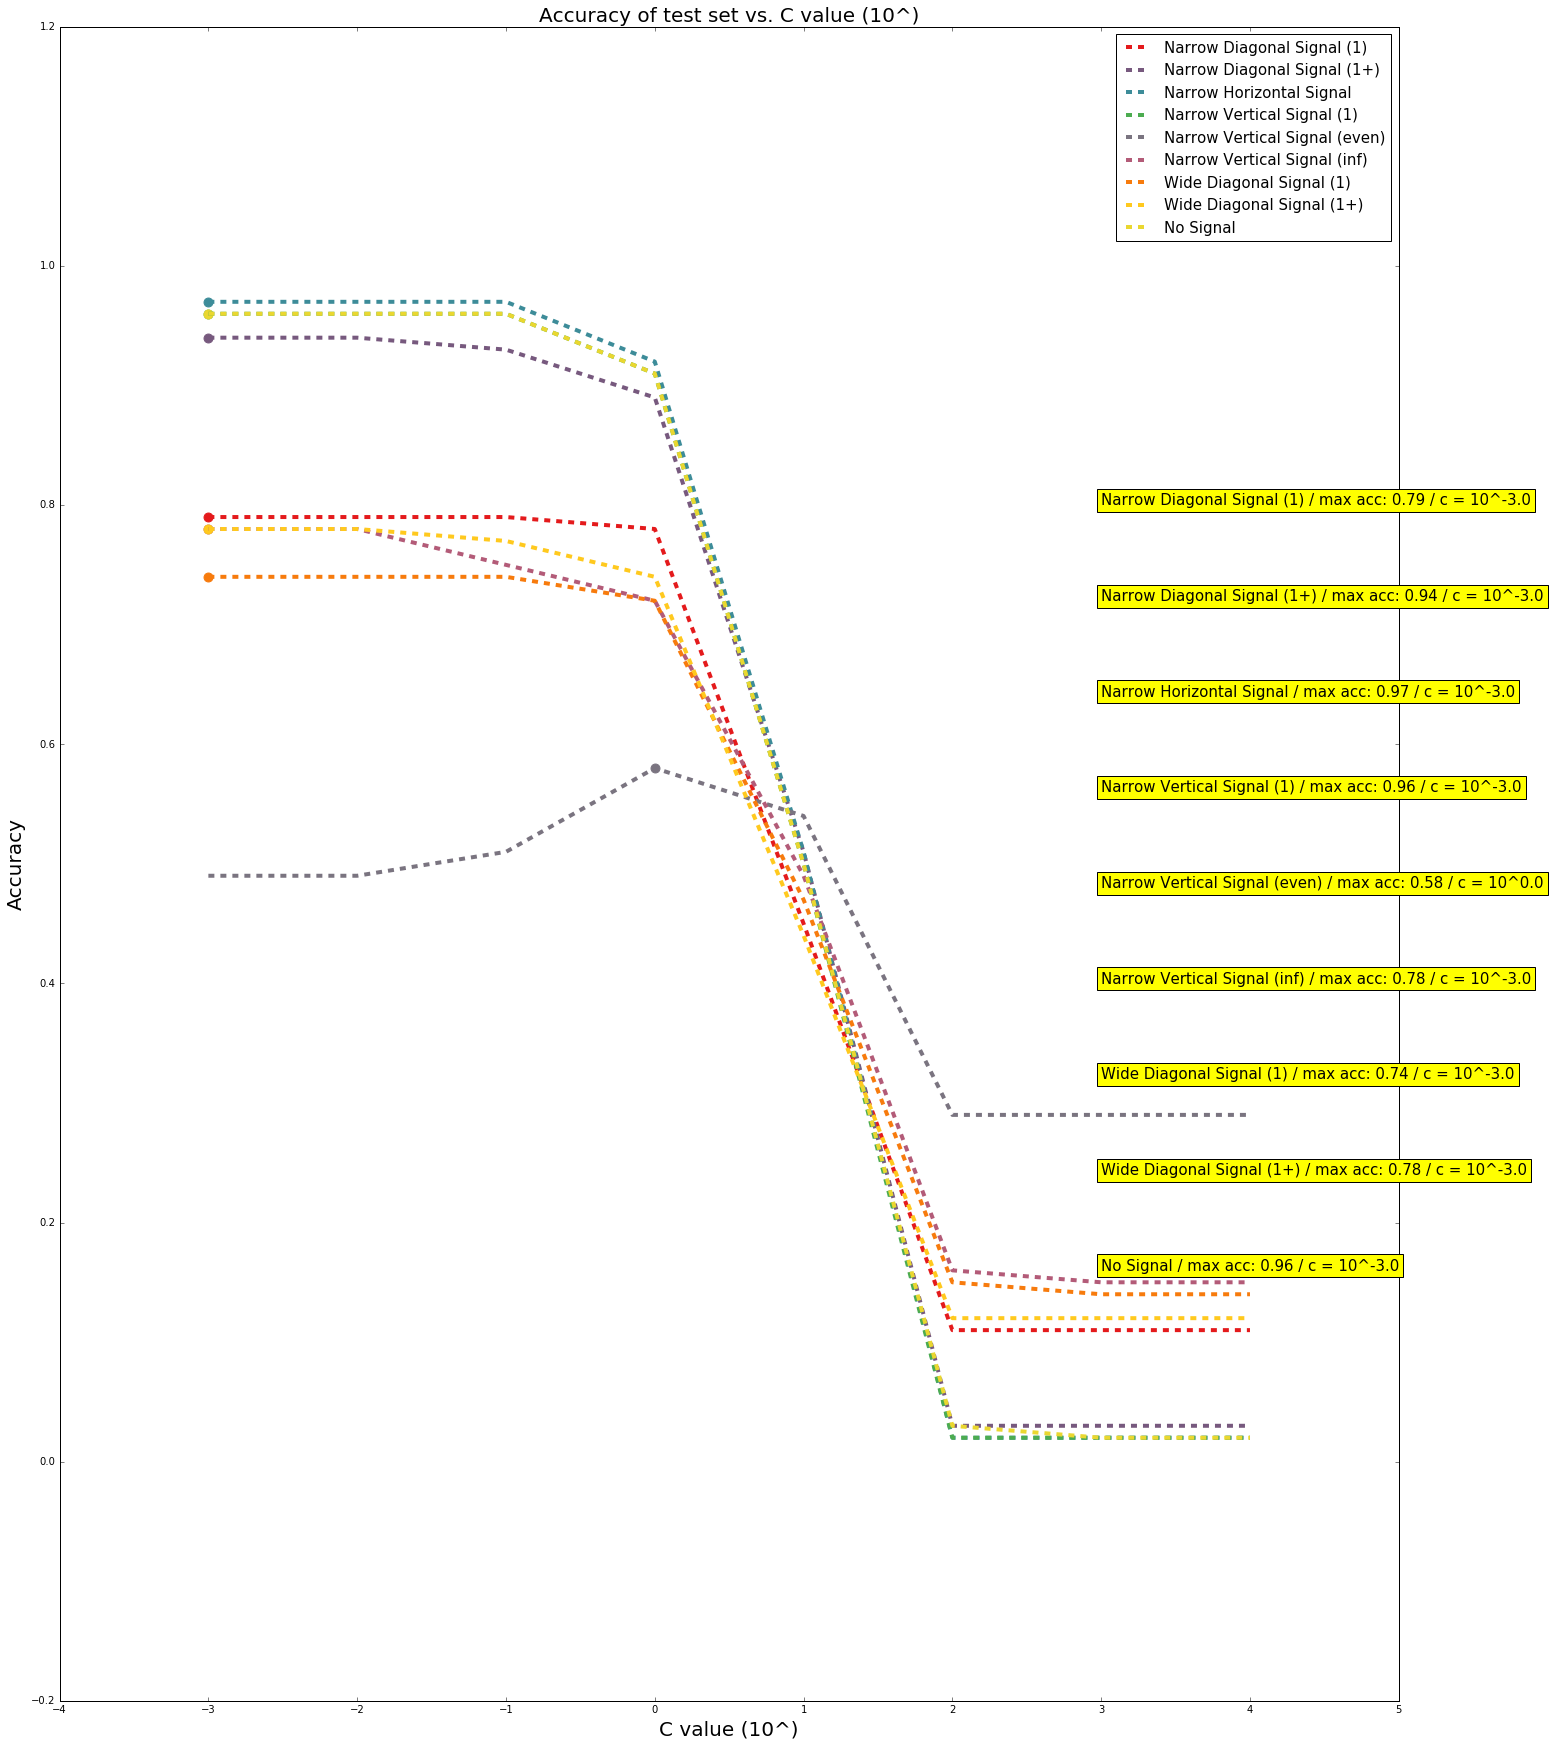

In [17]:
plot_SVM(t_SVM, 8)

# Multiclass


In [27]:
t_multiclass_SVM = Table(names=('C val (10^)', 'train_acc', 'acc_t'),
         dtype=('f8', 'f8', 'f8'))

t_multiclass_logreg = Table(names=('balanced', 'C val (10^)', 'train_acc', 'acc_t'),
         dtype=('U32', 'f8', 'f8', 'f8'))

t_multiclass_LDA = Table(names=('C val (10^)', 'train_acc', 'acc_t'),
         dtype=('f8', 'f8', 'f8'))

t_multiclass_QDA = Table(names=('C val (10^)', 'train_acc', 'acc_t'),
         dtype=('f8', 'f8', 'f8'))


In [22]:
f = pd.concat([f_ON, f_OFF])
        
for cat in removed_cat:
    f = f[f.feature != cat]

feat_cat_array = f.values
category_array = [x[-1] for x in feat_cat_array]
feature_array = [x[:-1] for x in feat_cat_array]

preprocessing.scale(feature_array)

train_data, test_data, train_target, test_target = train_test_split(feature_array, category_array, train_size = 0.8)  

## SVM

In [23]:
for c in range(1, 7):
    clf = SVC(kernel='rbf', C=10**c)

    clf.fit(train_data, train_target) 
    t_multiclass_SVM.add_row([c, round(clf.score(train_data, train_target), 2), 
              round(clf.score(test_data, test_target), 2)])

t_multiclass_SVM.show_in_notebook()

C val (10^),train_acc,acc_t
1.0,0.9,0.9
2.0,0.92,0.91
3.0,0.94,0.92
4.0,0.96,0.91
5.0,0.97,0.9
6.0,0.96,0.89


Confusion matrix, without normalization
[[376   0   0   1   0   0   0   0   1]
 [ 24  97   0   0   0   0   0   0   0]
 [  0   0  58   0   0   0   0   0   6]
 [  4   0   2  51  11   8   0   1   4]
 [  0   0   0   8 992  12   0   0   2]
 [  0   0   0   1  13 488   0   0   0]
 [  0   0   0   0   0   0 434  39   1]
 [  0   0   0   1   0   0  92 361   1]
 [  0   0   0   1   5   4   1   0  54]]


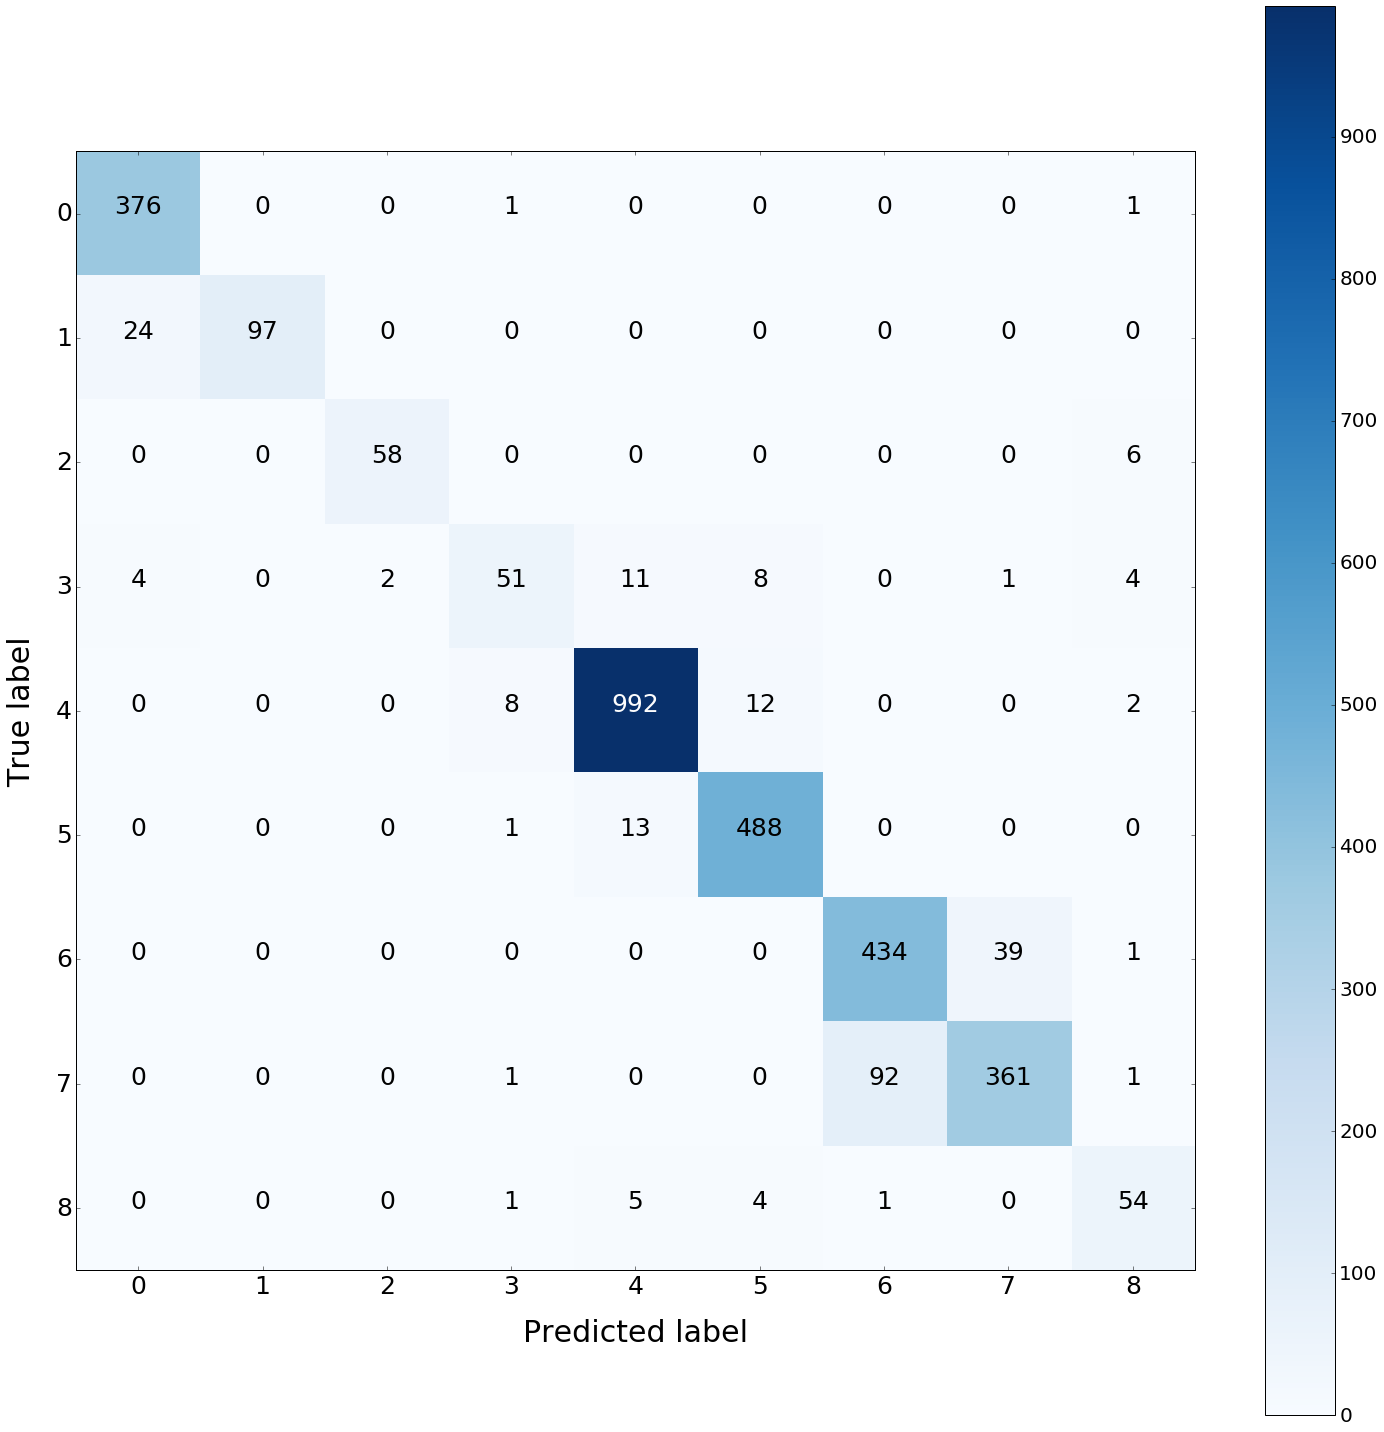

In [24]:
clf = SVC(kernel="rbf", C=10**3)
clf.fit(train_data, train_target) 
cnf_multi_SVM_matrix = confusion_matrix(test_target, clf.predict(test_data))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_multi_SVM_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                      title='Confusion matrix')

plt.savefig('books_read_2.png', transparent = True)

In [25]:
for x, y in zip(range(len(categories_mod)), categories_mod):
    print(str(x) + ": " + y)

0: Narrow Diagonal Signal (1)
1: Narrow Diagonal Signal (1+)
2: Narrow Horizontal Signal
3: Narrow Vertical Signal (1)
4: Narrow Vertical Signal (even)
5: Narrow Vertical Signal (inf)
6: Wide Diagonal Signal (1)
7: Wide Diagonal Signal (1+)
8: No Signal


## Logistic Regression

In [28]:
for c in range(-7, 7):
    for class_weight in ['balanced', None]:
        clf = linear_model.LogisticRegression(C=10**c, class_weight = class_weight)
        clf.fit(train_data, train_target) 

        t_multiclass_logreg.add_row([str(class_weight), c, round(clf.score(train_data, train_target), 2), 
                      round(clf.score(test_data, test_target), 2)])

t_multiclass_logreg.show_in_notebook()

balanced,C val (10^),train_acc,acc_t
balanced,-7.0,0.21,0.2
None,-7.0,0.3,0.31
balanced,-6.0,0.21,0.2
None,-6.0,0.3,0.31
balanced,-5.0,0.22,0.21
None,-5.0,0.3,0.31
balanced,-4.0,0.23,0.22
None,-4.0,0.3,0.31
balanced,-3.0,0.23,0.22
None,-3.0,0.3,0.31


Confusion matrix, without normalization
[[  0   0   0   0 338  40   0   0   0]
 [  0   0   0   0  16 105   0   0   0]
 [  0   0   0   0  59   5   0   0   0]
 [  0   0   0   0  54  27   0   0   0]
 [  0   0   0   0 783 231   0   0   0]
 [  0   0   0   0 308 194   0   0   0]
 [  0   0   0   0 457  17   0   0   0]
 [  0   0   0   0 384  71   0   0   0]
 [  0   0   0   0  61   4   0   0   0]]


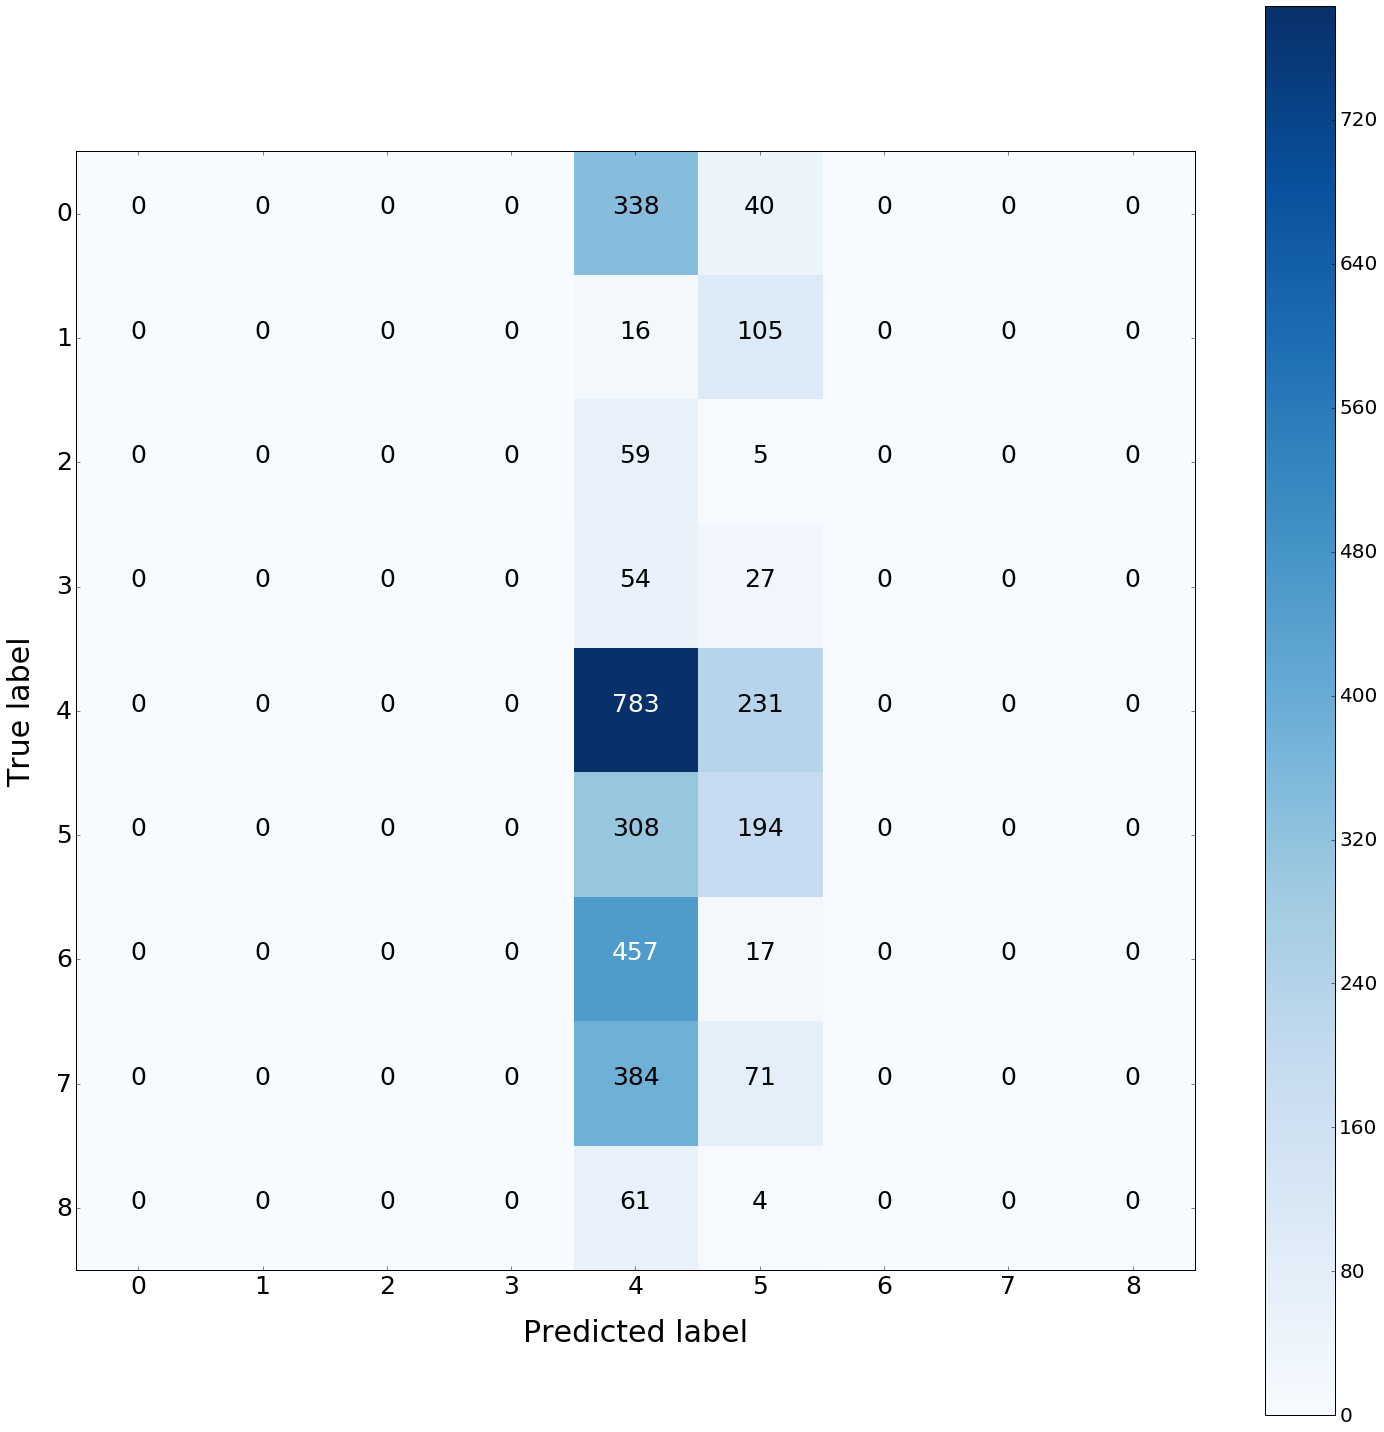

In [43]:
clf = linear_model.LogisticRegression(C=10**0)
clf.fit(train_data, train_target) 
cnf_multi_logreg_matrix = confusion_matrix(test_target, clf.predict(test_data))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_multi_logreg_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                      title='Confusion matrix')

plt.show()

## Linear Discriminant Analysis

In [30]:
for c in range(-5, 5):
    clf = LinearDiscriminantAnalysis()

    clf.fit(train_data, train_target) 
    t_multiclass_LDA.add_row([c, round(clf.score(train_data, train_target), 2), 
                  round(clf.score(test_data, test_target), 2)])

t_multiclass_LDA.show_in_notebook()

/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C val (10^),train_acc,acc_t
-5.0,0.84,0.85
-4.0,0.84,0.85
-3.0,0.84,0.85
-2.0,0.84,0.85
-1.0,0.84,0.85
0.0,0.84,0.85
1.0,0.84,0.85
2.0,0.84,0.85
3.0,0.84,0.85
4.0,0.84,0.85


Confusion matrix, without normalization
[[373   0   0   0   5   0   0   0   0]
 [ 24  96   0   0   0   0   0   1   0]
 [  1   0  47   0   1   0   0   0  15]
 [  1   0   0  38  33   7   0   1   1]
 [  3   0   0  26 955  30   0   0   0]
 [  0   0   0   3  45 454   0   0   0]
 [  0   0   0   0   1   0 335 138   0]
 [  2   0   0   0   3   0 119 331   0]
 [  0   0   0   0  23   2   0   1  39]]


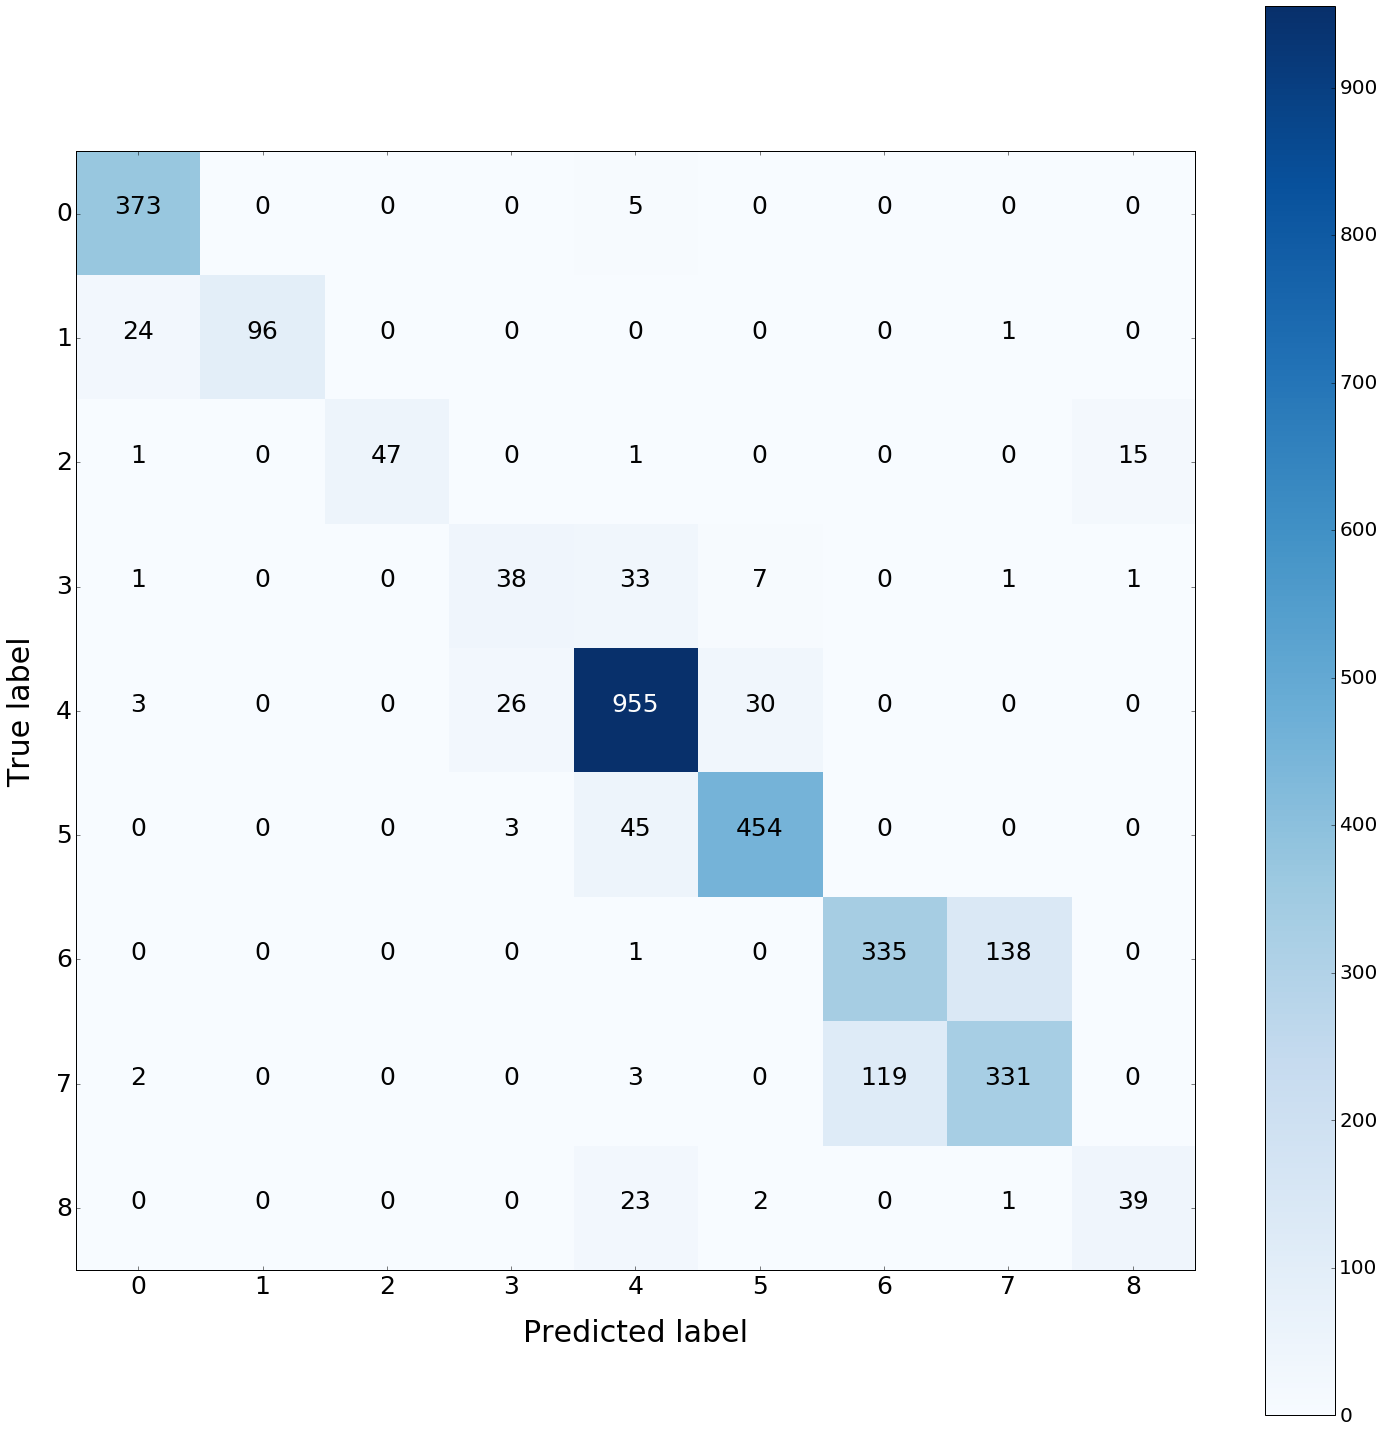

In [44]:
clf = LinearDiscriminantAnalysis()
clf.fit(train_data, train_target) 
cnf_multi_LDA_matrix = confusion_matrix(test_target, clf.predict(test_data))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_multi_LDA_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                      title='Confusion matrix')

plt.show()

## Quadratic Discriminant Analysis

In [32]:
for c in range(-5, 5):
    clf = QuadraticDiscriminantAnalysis()

    clf.fit(train_data, train_target) 
    t_multiclass_QDA.add_row([c, round(clf.score(train_data, train_target), 2), 
                  round(clf.score(test_data, test_target), 2)])

t_multiclass_QDA.show_in_notebook()

/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


C val (10^),train_acc,acc_t
-5.0,0.86,0.84
-4.0,0.86,0.84
-3.0,0.86,0.84
-2.0,0.86,0.84
-1.0,0.86,0.84
0.0,0.86,0.84
1.0,0.86,0.84
2.0,0.86,0.84
3.0,0.86,0.84
4.0,0.86,0.84


Confusion matrix, without normalization
[[366  10   0   2   0   0   0   0   0]
 [ 18 103   0   0   0   0   0   0   0]
 [  0   0  59   0   0   0   0   0   5]
 [ 10   0   0  53   4  10   1   0   3]
 [  0   0   0  38 774 199   0   0   3]
 [  0   0   0   4   8 490   0   0   0]
 [  1   0   0   0   0   0 437  36   0]
 [  0   0   0   0   0   0 123 332   0]
 [  4   0   2   3   1   2   1   2  50]]


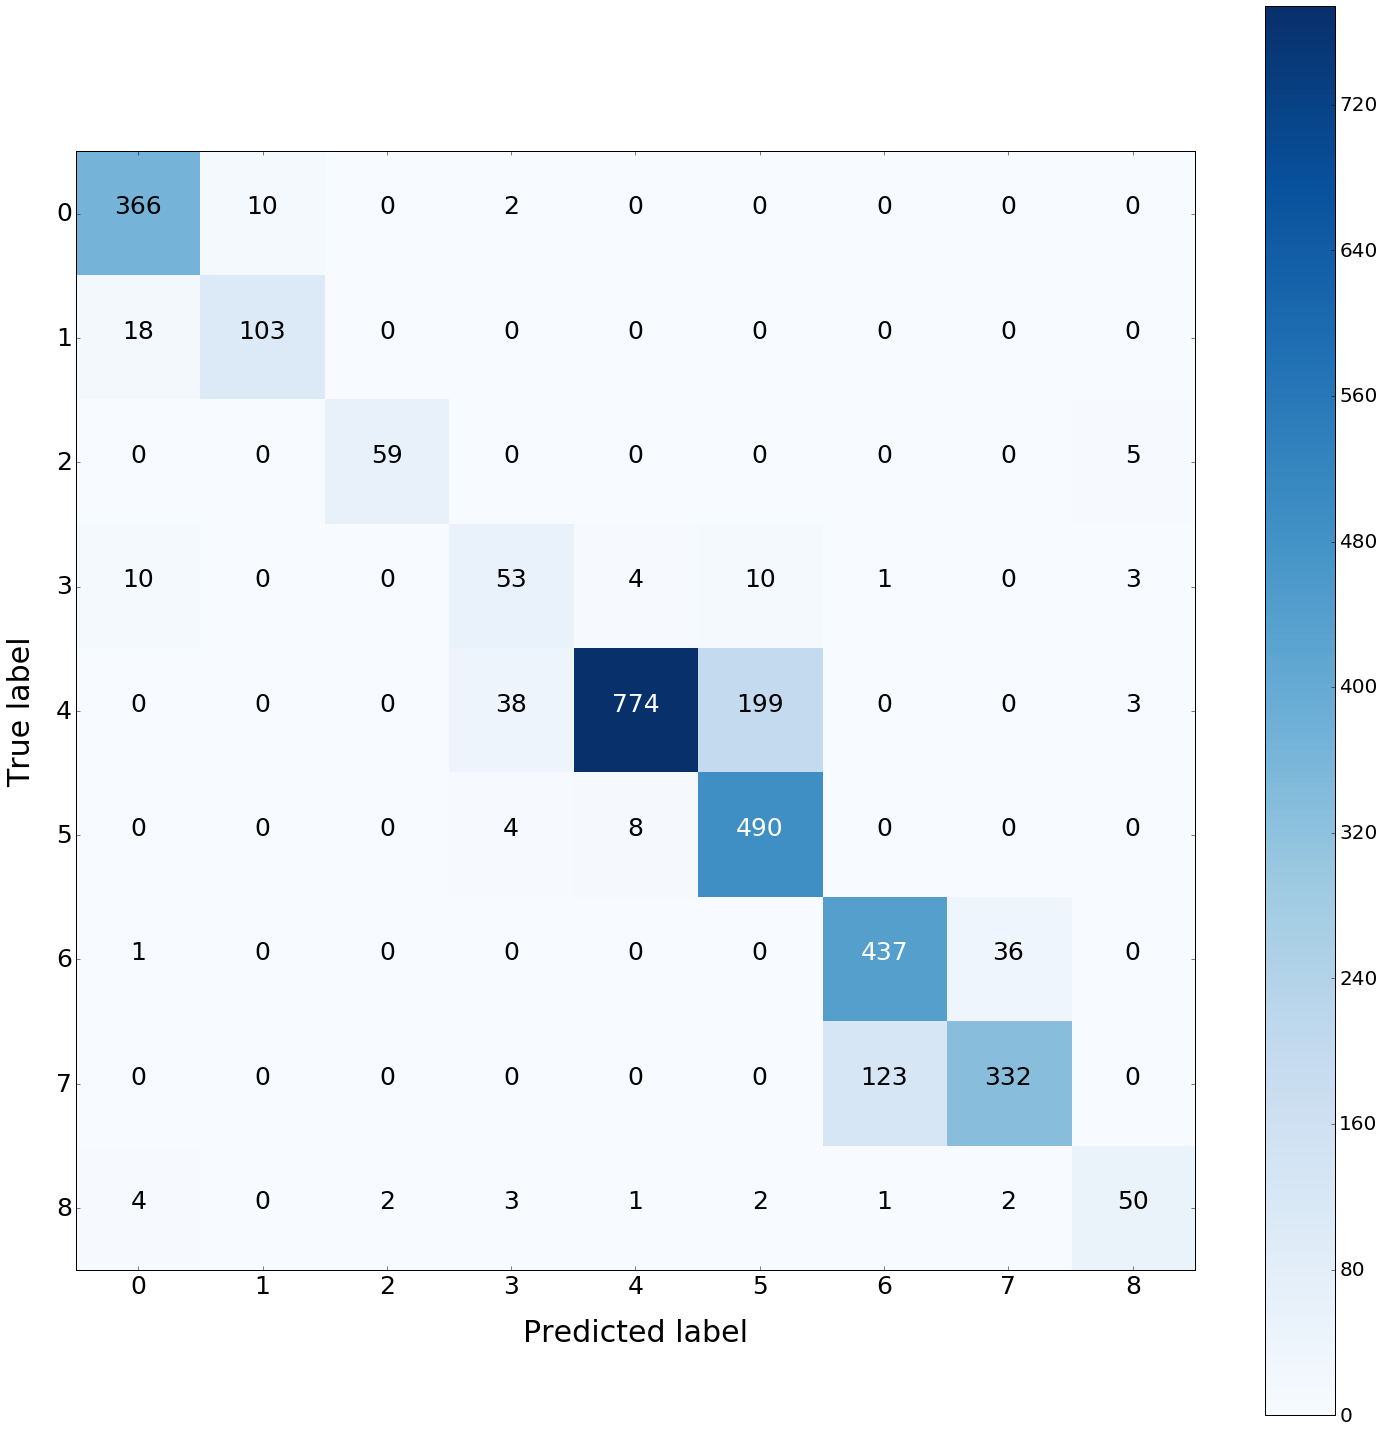

In [45]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(train_data, train_target) 
cnf_multi_QDA_matrix = confusion_matrix(test_target, clf.predict(test_data))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_multi_QDA_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                      title='Confusion matrix')

plt.savefig('books_read_2.png', transparent=True)

# Probabilities of All, Compared

In [34]:
prob_SVM = []                               # one v. rest SVM
prob_logreg = t_logreg['acc_t'].tolist()    # one v. rest logistic regression
prob_multi_SVM = []                         # multi SVM
prob_multi_logreg = []                      # multi logreg
prob_multi_LDA = []                         # multi LDA
prob_multi_QDA = []                         # multi QDA

probabilities = [prob_SVM, prob_logreg, prob_multi_SVM, prob_multi_logreg,
                prob_multi_LDA, prob_multi_QDA]

p_names = ['one_SVM', 'one_logreg', 'multi_SVM', 'multi_logreg',
            'multi_LDA', 'multi_QDA']

for x in range(0, len(t_SVM['acc_t']), 8):
    prob_SVM.append(max(t_SVM['acc_t'][x:(x + 8)]))

for x in range(len(cnf_multi_SVM_matrix)):
    prob_multi_SVM.append(cnf_multi_SVM_matrix[x][x] / sum(cnf_multi_SVM_matrix[x]))

for x in range(len(cnf_multi_logreg_matrix)):
    prob_multi_logreg.append(cnf_multi_logreg_matrix[x][x] / sum(cnf_multi_logreg_matrix[x]))

for x in range(len(cnf_multi_LDA_matrix)):
    prob_multi_LDA.append(cnf_multi_LDA_matrix[x][x] / sum(cnf_multi_LDA_matrix[x]))

for x in range(len(cnf_multi_QDA_matrix)):
    prob_multi_QDA.append(cnf_multi_QDA_matrix[x][x] / sum(cnf_multi_QDA_matrix[x]))


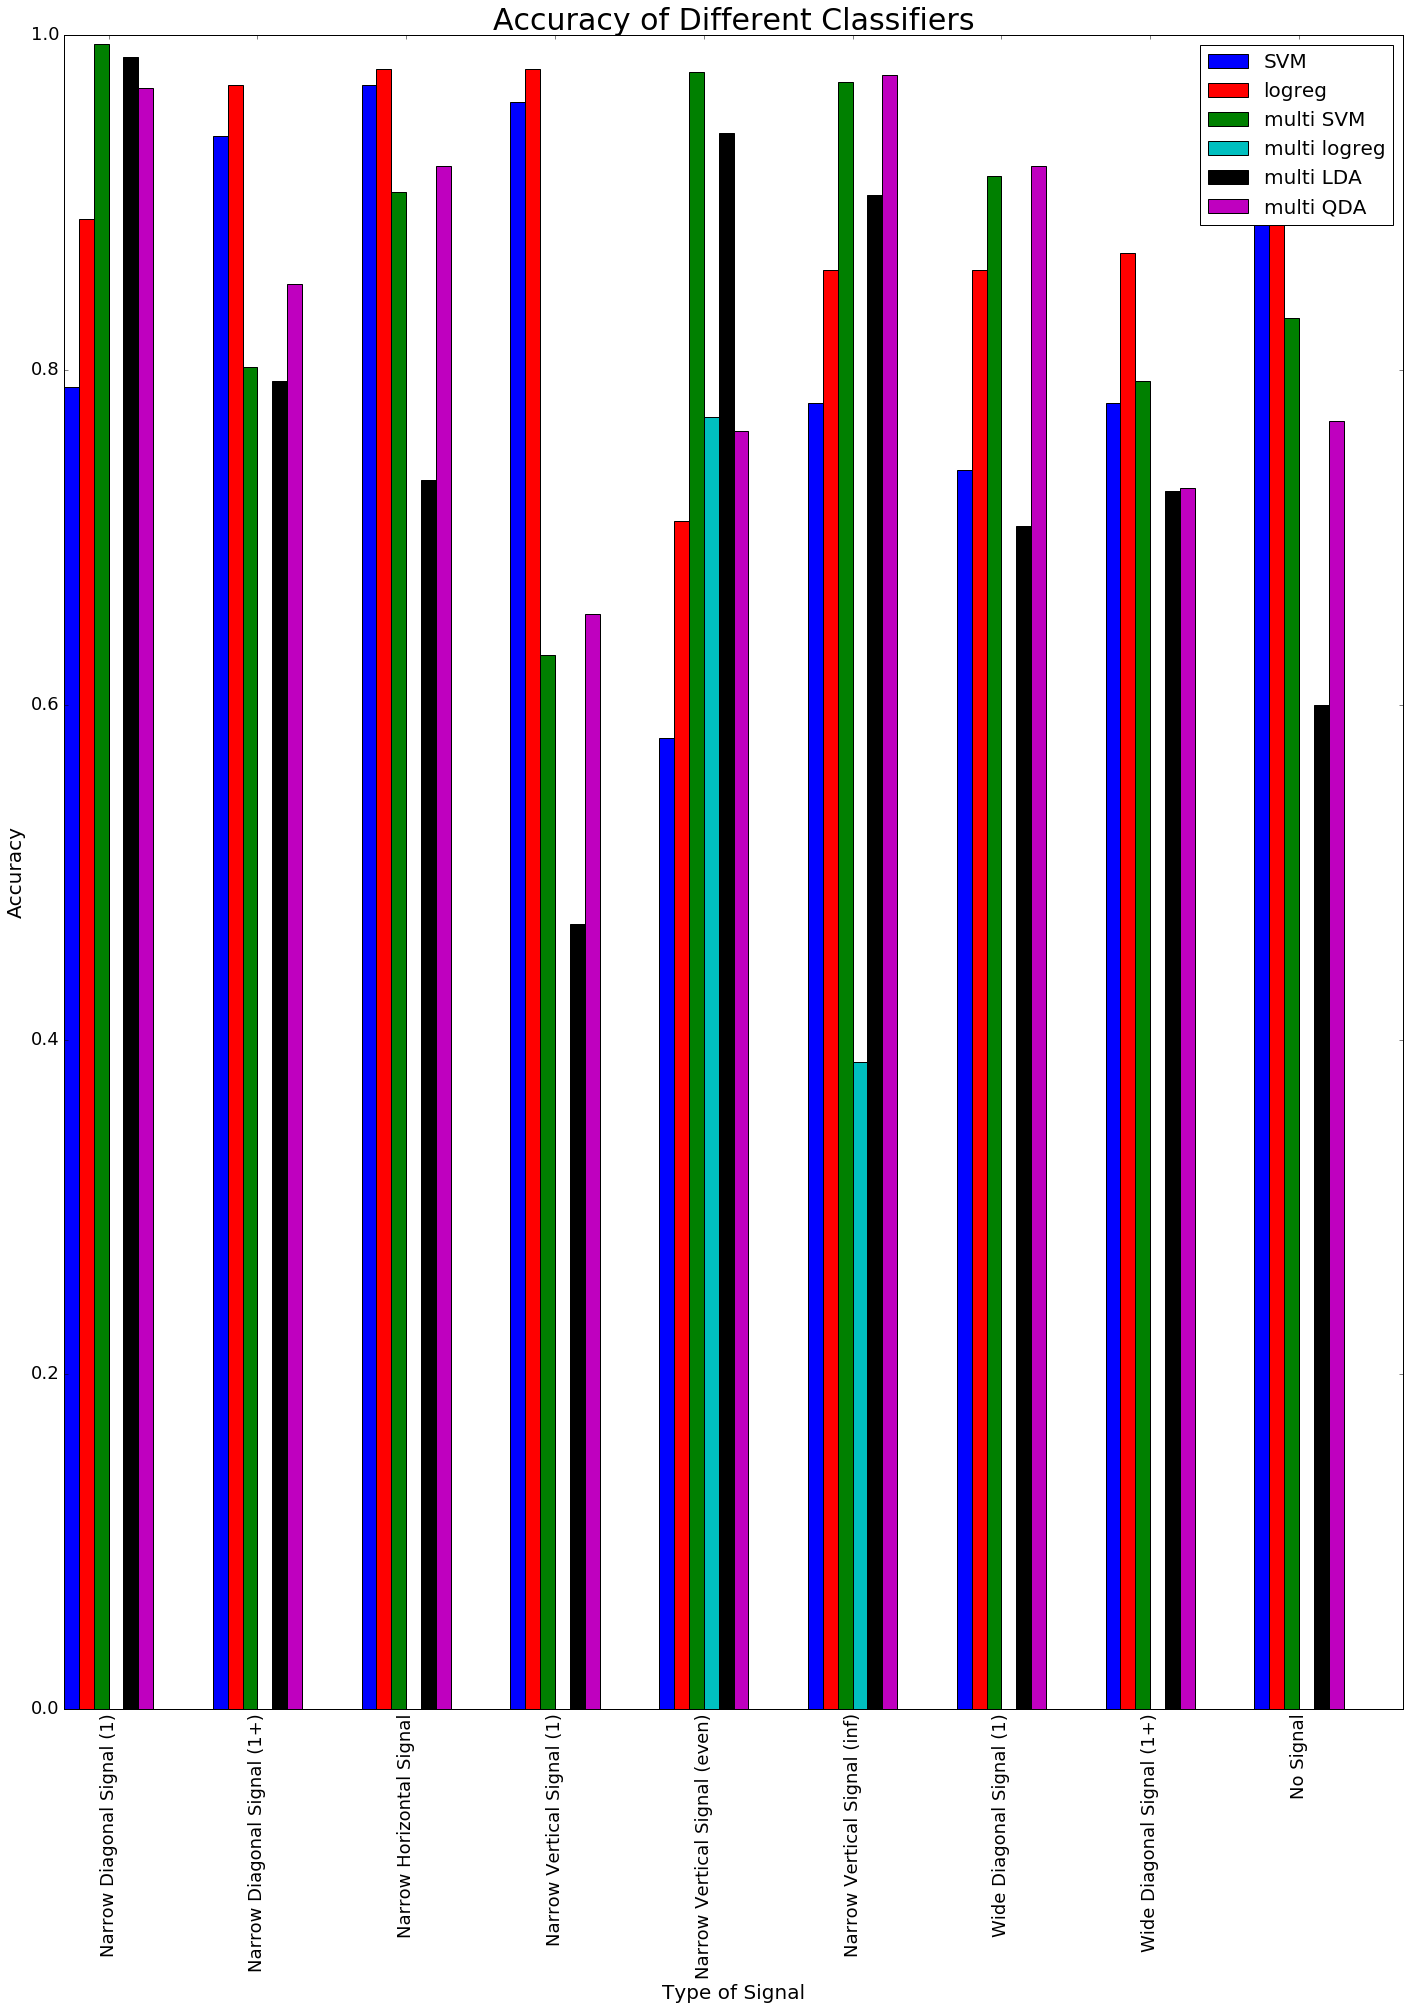

Narrow Diagonal Signal (1) : multi_SVM: 0.99
Narrow Diagonal Signal (1+) : one_logreg: 0.97
Narrow Horizontal Signal : one_logreg: 0.98
Narrow Vertical Signal (1) : one_logreg: 0.98
Narrow Vertical Signal (even) : multi_SVM: 0.98
Narrow Vertical Signal (inf) : multi_QDA: 0.98
Wide Diagonal Signal (1) : multi_QDA: 0.92
Wide Diagonal Signal (1+) : one_logreg: 0.87
No Signal : one_logreg: 0.98


In [35]:
fig, ax = plt.subplots()

ind = np.arange(len(probabilities[0]))
w = 0.1

p0 = ax.bar(ind, probabilities[0], width = w, color = 'b')
p1 = ax.bar(ind + w, probabilities[1], width = w, color = 'r')
p2 = ax.bar(ind + 2 * w, probabilities[2], width = w, color = 'g')
p3 = ax.bar(ind + 3 * w, probabilities[3], width = w, color = 'c')
p4 = ax.bar(ind + 4 * w, probabilities[4], width = w, color = 'k')
p5 = ax.bar(ind + 5 * w, probabilities[5], width = w, color = 'm')

ax.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]),
          ('SVM', 'logreg', 'multi SVM', 'multi logreg', 'multi LDA', 'multi QDA'),
          fontsize='20')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

ax.set_ylabel('Accuracy', fontsize='20')
ax.set_xlabel('Type of Signal', fontsize='20')
ax.set_title("Accuracy of Different Classifiers", fontsize=30)

ax.set_xticks((ind + 0.1* len(probabilities) / 2))
ax.set_xticklabels(categories_mod)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.show()

for p in range(len(probabilities[0])):
    max_index, max_value = max(enumerate([prob[p] for prob in probabilities]),
                               key=operator.itemgetter(1))
    print(categories_mod[p] + " : " + p_names[max_index] + ": " + str(round(max_value, 2)))

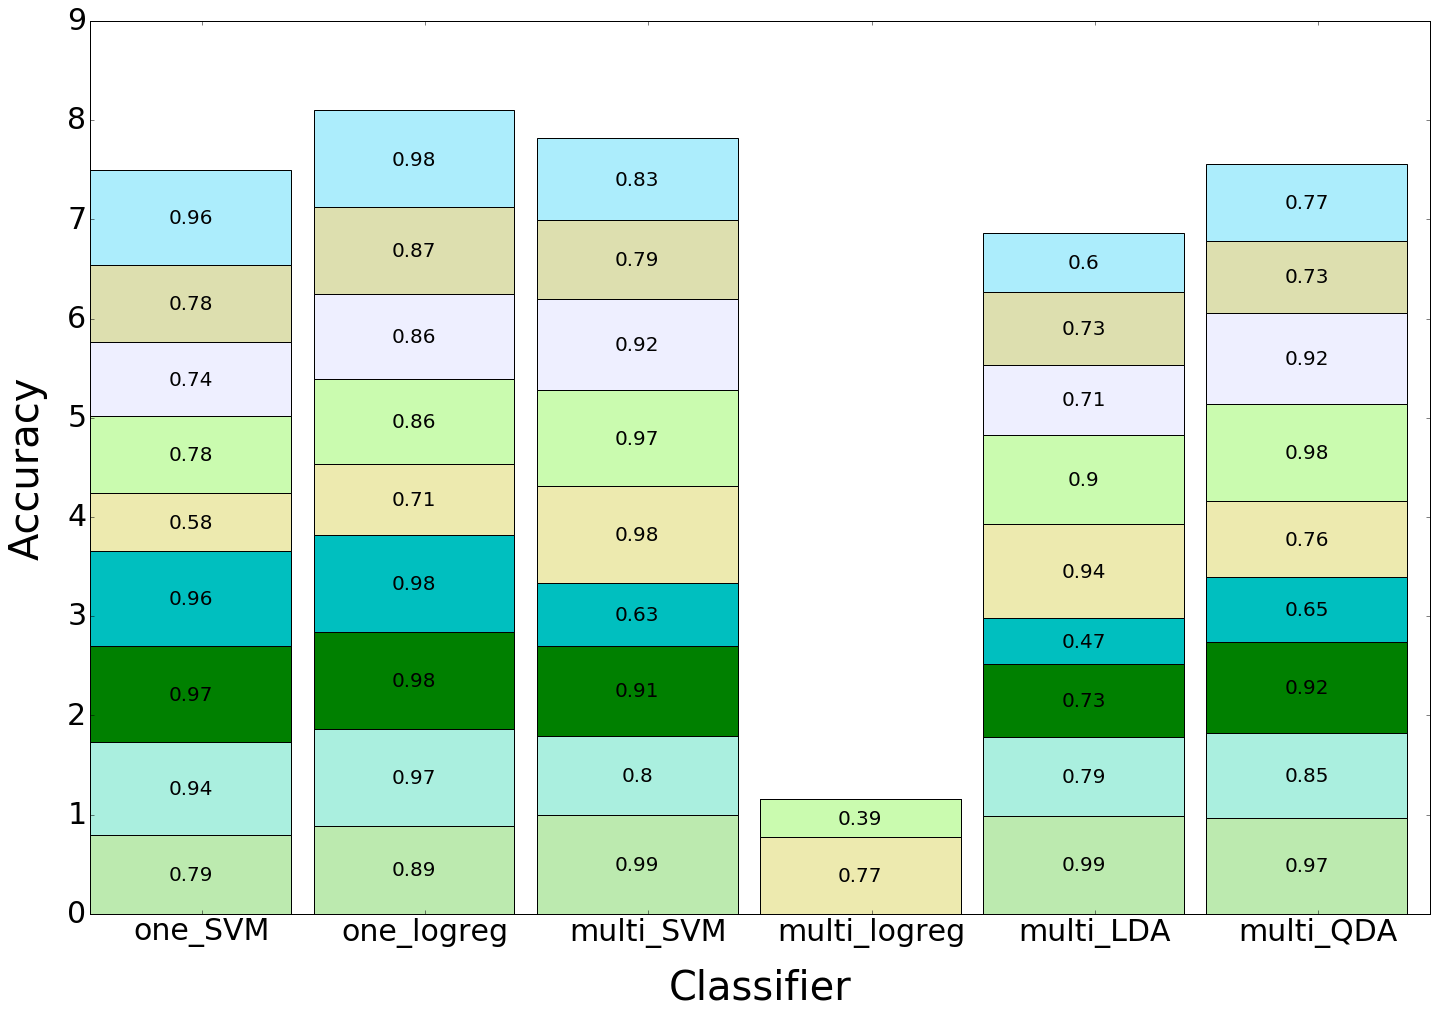

In [36]:
import pylab, numpy 

fig, ax = plt.subplots()

ind = np.arange(len(probabilities))
w = 0.9

f0 = [f[0] for f in probabilities]
f1 = [f[1] for f in probabilities]
f2 = [f[2] for f in probabilities]
f3 = [f[3] for f in probabilities]
f4 = [f[4] for f in probabilities]
f5 = [f[5] for f in probabilities]
f6 = [f[6] for f in probabilities]
f7 = [f[7] for f in probabilities]
f8 = [f[8] for f in probabilities]

p0 = ax.bar(ind, f0, width = w, color = '#bceaaf')

p1 = ax.bar(ind, f1, width = w, bottom = f0, color = '#aaefdf')
p2 = ax.bar(ind, f2, width = w, bottom = [sum(x) for x in zip(f0, f1)], color = 'g')
p3 = ax.bar(ind, f3, width = w, bottom = list(map(sum, zip(f0, f1, f2))), color = 'c')
p4 = ax.bar(ind, f4, width = w, bottom = list(map(sum, zip(f0, f1, f2, f3))), color = '#edeaaf')
p5 = ax.bar(ind, f5, width = w, bottom = list(map(sum, zip(f0, f1, f2, f3, f4))), color = '#cafbaf')
p6 = ax.bar(ind, f6, width = w, bottom = list(map(sum, zip(f0, f1, f2, f3, f4, f5))), color = '#eeefff')
p7 = ax.bar(ind, f7, width = w, bottom = list(map(sum, zip(f0, f1, f2, f3, f4, f5, f6))), color = '#dddfaf')
p8 = ax.bar(ind, f8, width = w, bottom = list(map(sum, zip(f0, f1, f2, f3, f4, f5, f6, f7))), color = '#acedfc')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

ax.set_ylabel('Accuracy', fontsize='40', labelpad=20)
ax.set_xlabel('Classifier', fontsize='40', labelpad=20)
# ax.set_title("Accuracy of Different Classifiers", fontsize=30)

ax.set_xticks(ind + 0.5)
ax.set_xticklabels(p_names)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=30)

rects = ax.patches

labels = []
for x in range(len(probabilities[0])):
    labels.extend([item[x] for item in probabilities])
labels = [round(e, 2) for e in labels]
# Now make some labels

height = [0, 0, 0, 0, 0, 0]
counter=0
for rect, label in zip(rects, labels):
    
    x = counter%6
    height[x] += rect.get_height()/2
    if (label != 0):
        ax.text(rect.get_x() + rect.get_width()/2, height[x]-0.1, label, ha='center', va='bottom', fontsize='20')
    height[x] += rect.get_height()/2
    counter += 1

In [37]:
tables = [t_SVM, t_logreg, t_multiclass_SVM, t_multiclass_logreg, t_multiclass_LDA, t_multiclass_QDA]

print("Overall Accuracies:")
for x in range(len(p_names)):
    print(p_names[x] + ": " + str(max(tables[x]['acc_t'])))

Overall Accuracies:
one_SVM: 0.97
one_logreg: 0.98
multi_SVM: 0.92
multi_logreg: 0.31
multi_LDA: 0.85
multi_QDA: 0.84


# Chaining One Class Classifiers (Unsuccessful)

## Functions + constants

In [38]:
print_list = []

def chain_SVM(order, p = False):
    
    global print_list
    
    df = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df = df.loc[result_files_ON]

    df_OFF = pd.read_pickle('binary_log_hog_dataframe.pkl')
    df_OFF = df_OFF.loc[result_files_OFF]

    for f in order:

        feature_ON = ON_files.get_data(f)
        feature_OFF = OFF_files.get_data(f)

        df['feature'] = pd.Series(np.full((df.shape[0],), 1), index=df.index)

        df_mod = df[relevant_features_ON]
        df_mod.loc[feature_ON, 'feature'] = -1

        target = df_mod['feature']
        outliers = target[target == -1]  
        df_mod.drop(["feature"], axis=1, inplace=True)

        df_OFF['feature'] = pd.Series(np.full((df_OFF.shape[0],), 1), index=df_OFF.index)

        df_OFF_mod = df_OFF[relevant_features_OFF]

        df_OFF_mod.loc[feature_OFF, 'feature'] = -1

        target_OFF = df_OFF_mod['feature']
        outliers_OFF = target_OFF[target_OFF == -1]  
        df_OFF_mod.drop(["feature"], axis=1, inplace=True)

        preprocessing.scale(df_mod)
        preprocessing.scale(df_OFF_mod)

        train_data_ON, test_data_ON, train_target_ON, test_target_ON = train_test_split(df_mod, target, train_size = 0.8)  
        train_data_OFF, test_data_OFF, train_target_OFF, test_target_OFF = train_test_split(df_OFF_mod, target_OFF, train_size = 0.8)  

        train_data_ON.columns = relevant_features
        train_data_OFF.columns = relevant_features
        test_data_ON.columns = relevant_features
        test_data_OFF.columns = relevant_features

        train_data = pd.concat([train_data_ON, train_data_OFF])
        test_data = pd.concat([test_data_ON, test_data_OFF])
        train_target = train_target_ON.append(train_target_OFF)
        test_target = test_target_ON.append(test_target_OFF)

        nu = (outliers.shape[0] + outliers_OFF.shape[0]) / (target.shape[0] + target_OFF.shape[0])

        model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=10**-3)  
        model.fit(train_data)  
        preds = model.predict(train_data)  
        targs = train_target

        preds = model.predict(test_data)  
        targs = test_target

        acc_t = round(metrics.accuracy_score(targs, preds), 2)
        prec_t = round(metrics.precision_score(targs, preds), 2)
        recall_t = round(metrics.recall_score(targs, preds), 2)
        f1_t = round(metrics.f1_score(targs, preds), 2)
        auc_t = round(metrics.average_precision_score(targs, model.decision_function(test_data)), 2)

        if p:
            print(f)
            print(categories_mod[f])
            print(acc_t)
            print(prec_t)
            print(recall_t)
            print(f1_t)
            print(auc_t)
            print("")

        print_list.append(acc_t)

        df = df.drop(feature_ON)
        df_OFF = df_OFF.drop(feature_OFF)

In [39]:
in_order = [0, 1, 2, 3, 4, 5, 6, 7, 8]
highest_to_least = [8, 2, 3, 1, 0, 5, 6, 7, 4]
least_to_highest = [4, 7, 6, 5, 0, 1, 3, 2, 8]

orders = [in_order, highest_to_least, least_to_highest]

indiv_p = [len(x) / sum([len(x) for x in ALL_files.get_data()]) for x in ALL_files.get_data()]

for o in orders:
    print_list = []

    chain_SVM(o)
    mod_prob_SVM = [[round(elem, 2) for elem in prob_SVM][i] for i in o]
    mod_indiv_p = [indiv_p[i] for i in o]
    
    print("(one class SVM prob, chained prob)")
    print(zip([round(elem, 2) for elem in mod_prob_SVM], print_list))
    
    print("overall accuracy: " + str(sum([mod_indiv_p[x] * print_list[x] for x in range(len(print_list))])))
#     print(zip([round(elem, 2) for elem in indiv_p], print_list))
    print("")

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(one class SVM prob, chained prob)
[(0.79, 0.78), (0.94, 0.93), (0.97, 0.96), (0.96, 0.95), (0.58, 0.4), (0.78, 0.69), (0.74, 0.49), (0.78, 0.47), (0.96, 0.69)]
overall accuracy: 0.565513231504

(one class SVM prob, chained prob)
[(0.96, 0.96), (0.97, 0.97), (0.96, 0.96), (0.94, 0.93), (0.79, 0.77), (0.78, 0.75), (0.74, 0.63), (0.78, 0.66), (0.58, 0.62)]
overall accuracy: 0.699803256019

(one class SVM prob, chained prob)
[(0.58, 0.5), (0.78, 0.67), (0.74, 0.59), (0.78, 0.54), (0.79, 0.36), (0.94, 0.68), (0.96, 0.79), (0.97, 0.72), (0.96, 0.69)]
overall accuracy: 0.550951034006

